[23:36:31] Training LogisticRegression…
[23:36:31] Training DecisionTree…
[23:36:31] Training RandomForest…
[23:36:31] Training GradientBoosting…
[23:36:32] Training AdaBoost…
[23:36:33] Training GaussianNB…
[23:36:33] Training LightGBM…
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3817, number of negative: 3817
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1557
[LightGBM] [Info] Number of data points in the train set: 7634, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[23:36:33] Training XGBoost…


F:\stroke-prediction-project\stroke-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:36:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[23:36:33] Training SVM…
[23:36:38] Training KNN…
[23:36:39] Training Voting_Soft…
[23:36:44] Training Voting_Hard…

=== Models Ordered by F1 Score ===


,Accuracy (%),F1 Score (%),Precision (%),Recall (%),ROC-AUC (%),PR-AUC (%),Train Time (s)
XGBoost,90.410959,26.865672,21.428571,36.0,80.695473,18.199063,0.09
Voting_Soft,86.203523,24.598930,16.788321,46.0,81.267490,19.452372,5.20
LogisticRegression,75.146771,23.952096,14.084507,80.0,84.257202,26.230193,0.01
GradientBoosting,81.213307,23.200000,14.500000,58.0,80.190329,14.261734,0.90
LightGBM,90.704501,22.764228,19.178082,28.0,79.435185,19.201974,0.08
Voting_Hard,85.225049,22.564103,15.172414,44.0,65.672840,9.415588,5.98
SVM,75.636008,22.429907,13.284133,72.0,80.582305,15.406854,5.04
AdaBoost,73.483366,22.349570,13.043478,78.0,81.541152,19.702574,0.23
KNN,85.127202,21.649485,14.583333,42.0,69.846708,12.045510,0.02
RandomForest,89.530333,19.548872,15.662651,26.0,80.564815,14.912438,0.70


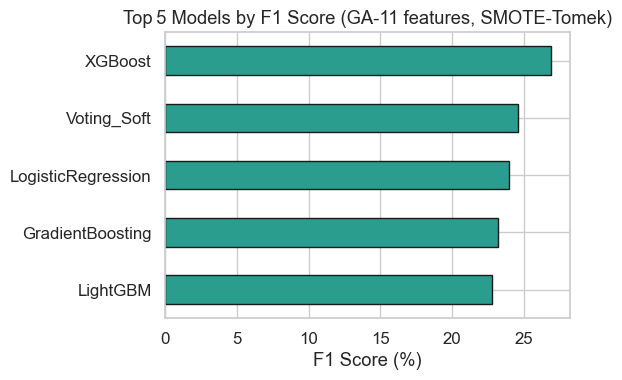

In [9]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, VotingClassifier
)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score
)
from imblearn.combine import SMOTETomek

sns.set(style="whitegrid", font_scale=1.1)

# ─── 0) Paths & GA‐features ──────────────────────────────────────────────
BASE_DIR    = r'F:\stroke-prediction-project'
RAW_DIR     = os.path.join(BASE_DIR, 'data', 'processed')
CHARM_DIR   = os.path.join(BASE_DIR, 'data', 'charm')
FIG_DIR     = os.path.join(BASE_DIR, 'figures', 'mlga')
os.makedirs(CHARM_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# 1) Load GA‐11 feature list
feats = pd.read_csv(os.path.join(CHARM_DIR, 'ga_stable11.csv'))['feature'].tolist()

# 2) Load raw train/test and slice to GA‐11
X_train_raw = pd.read_csv(os.path.join(RAW_DIR, 'X_train.csv'))
y_train_raw = pd.read_csv(os.path.join(RAW_DIR, 'y_train.csv'))['stroke']
X_test      = pd.read_csv(os.path.join(RAW_DIR, 'X_test.csv'))
y_test      = pd.read_csv(os.path.join(RAW_DIR, 'y_test.csv'))['stroke']

X_train_11 = X_train_raw[feats]
# ─── 3) SMOTE + Tomek on GA‐11 features ────────────────────────────────
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train_11, y_train_raw)

# 4) Save resampled splits for all downstream scripts
X_res.to_csv(os.path.join(CHARM_DIR, 'X_resampled.csv'), index=False)
pd.DataFrame({'stroke': y_res}).to_csv(
    os.path.join(CHARM_DIR, 'y_resampled.csv'), index=False
)

# ─── 5) Define & fit all models ────────────────────────────────────────
models = {
    'LogisticRegression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42)),
    'DecisionTree'       : DecisionTreeClassifier(random_state=42),
    'RandomForest'       : RandomForestClassifier(random_state=42),
    'GradientBoosting'   : GradientBoostingClassifier(random_state=42),
    'AdaBoost'           : AdaBoostClassifier(random_state=42),
    'GaussianNB'         : GaussianNB(),
    'LightGBM'           : LGBMClassifier(random_state=42),
    'XGBoost'            : XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'SVM'                : make_pipeline(StandardScaler(), SVC(probability=True, random_state=42)),
    'KNN'                : make_pipeline(StandardScaler(), KNeighborsClassifier())
}
# add voting
models['Voting_Soft'] = VotingClassifier(
    estimators=[(name, mdl) for name, mdl in models.items()],
    voting='soft', n_jobs=-1
)
models['Voting_Hard'] = VotingClassifier(
    estimators=[(name, mdl) for name, mdl in models.items()],
    voting='hard', n_jobs=-1
)

# ─── 6) Train, predict & collect metrics ───────────────────────────────
metrics = {}
for name, mdl in models.items():
    print(f"[{time.strftime('%H:%M:%S')}] Training {name}…")
    t0 = time.time()
    mdl.fit(X_res, y_res)
    dt = time.time() - t0

    y_pred  = mdl.predict(X_test[feats])
    if hasattr(mdl, 'predict_proba'):
        y_proba = mdl.predict_proba(X_test[feats])[:,1]
    else:
        # hard voting or others
        y_proba = y_pred

    metrics[name] = {
        'Accuracy (%)': accuracy_score(y_test,  y_pred)*100,
        'F1 Score (%)': f1_score(y_test,      y_pred)*100,
        'Precision (%)': precision_score(y_test, y_pred)*100,
        'Recall (%)': recall_score(y_test,    y_pred)*100,
        'ROC-AUC (%)': roc_auc_score(y_test,  y_proba)*100,
        'PR-AUC (%)': average_precision_score(y_test, y_proba)*100,
        'Train Time (s)': round(dt,2)
    }

# ─── 7) Tabulate & save ────────────────────────────────────────────────
df = pd.DataFrame(metrics).T
df.to_csv(os.path.join(CHARM_DIR, 'model_comparison.csv'))
print("\n=== Models Ordered by F1 Score ===")
display(df.sort_values('F1 Score (%)', ascending=False))

# Optionally: plot a nice bar-chart of the top 5 F1s
top5 = df.sort_values('F1 Score (%)', ascending=False).head(5)
ax = top5['F1 Score (%)'].plot.barh(figsize=(6,4), color='#2a9d8f', edgecolor='k')
ax.invert_yaxis()
ax.set_xlabel('F1 Score (%)')
ax.set_title('Top 5 Models by F1 Score (GA-11 features, SMOTE-Tomek)')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'top5_f1_ga11.png'), dpi=300)
plt.savefig(os.path.join(FIG_DIR, 'top5_f1_ga11.pdf'), dpi=300)
plt.show()

In [10]:
# # 1. Load GA-selected feature names
# feats = pd.read_csv(r'F:\stroke-prediction-project\data\charm\ga_stable11.csv')['feature'].tolist()

# # 2. Load only those columns for train & test
# X_train = pd.read_csv(r'F:\stroke-prediction-project\data\processed\X_resampled.csv')[feats]
# y_train = pd.read_csv(r'F:\stroke-prediction-project\data\processed\y_resampled.csv')['stroke']
# X_test  = pd.read_csv(r'F:\stroke-prediction-project\data\processed\X_test.csv')[feats]
# y_test  = pd.read_csv(r'F:\stroke-prediction-project\data\processed\y_test.csv')['stroke']

# # Output directory for figures
# out_dir = r'F:\stroke-prediction-project\figures\mlga'
# os.makedirs(out_dir, exist_ok=True)

Columns available for plotting:
 ['Accuracy (%)', 'F1 Score (%)', 'Precision (%)', 'Recall (%)', 'ROC-AUC (%)', 'PR-AUC (%)', 'Train Time (s)'] 

Metrics to plot: ['Accuracy (%)', 'F1 Score (%)', 'Precision (%)', 'Recall (%)', 'ROC-AUC (%)', 'PR-AUC (%)']
Metric 'Accuracy (%)' → best: LightGBM (90.70)
Metric 'F1 Score (%)' → best: XGBoost (26.87)
Metric 'Precision (%)' → best: XGBoost (21.43)
Metric 'Recall (%)' → best: GaussianNB (98.00)
Metric 'ROC-AUC (%)' → best: LogisticRegression (84.26)
Metric 'PR-AUC (%)' → best: LogisticRegression (26.23)


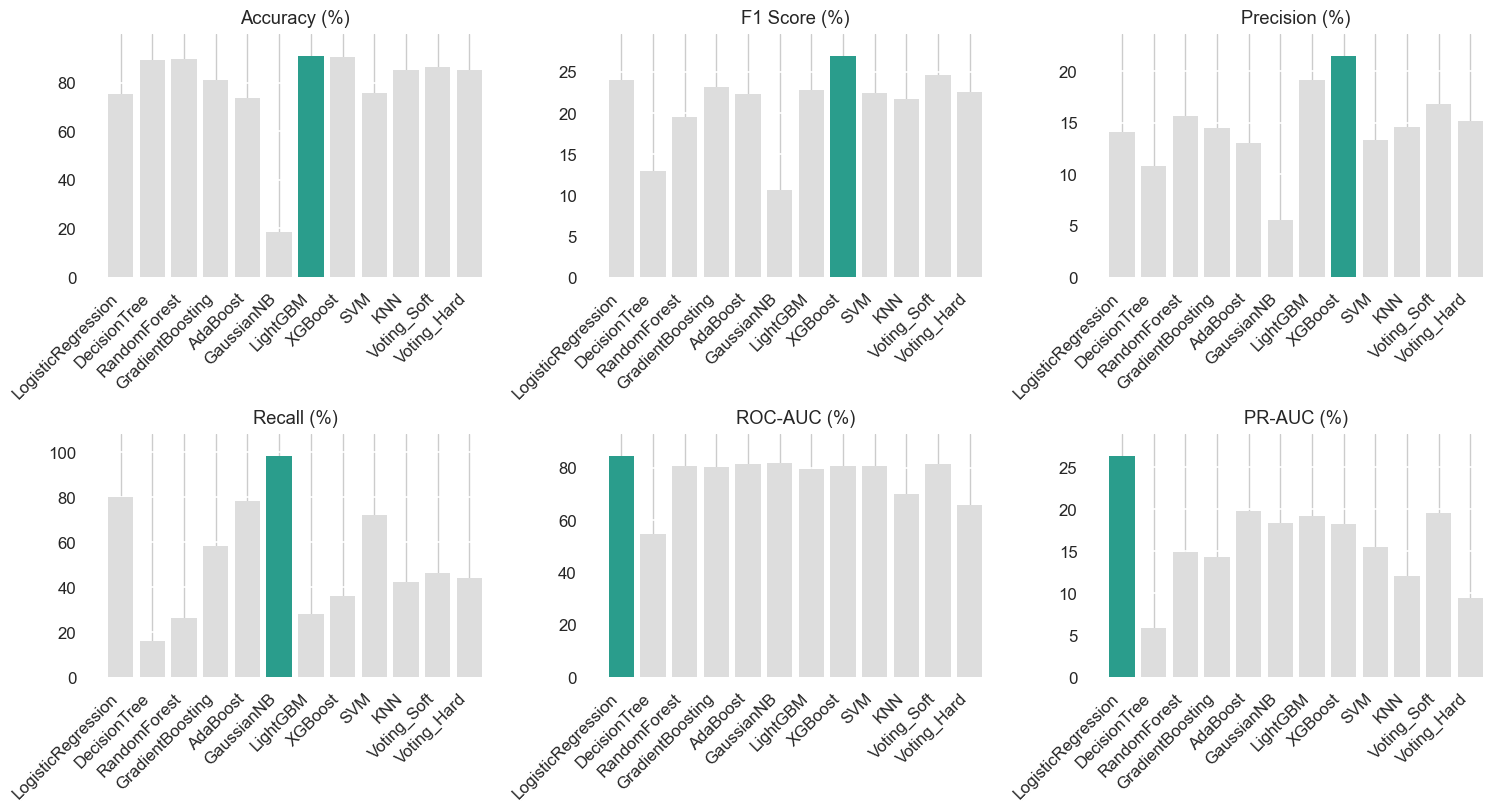

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) load exactly what you're plotting
CHARM_DIR = r'F:\stroke-prediction-project\data\charm'
FIG_DIR   = r'F:\stroke-prediction-project\figures\mlga'
os.makedirs(FIG_DIR, exist_ok=True)

df = pd.read_csv(os.path.join(CHARM_DIR, 'model_comparison.csv'), index_col=0)

# 2) inspect to be sure
print("Columns available for plotting:\n", list(df.columns), "\n")

# Per your earlier code, we want everything except Train Time in the 2×3 grid:
metrics = [c for c in df.columns if c != 'Train Time (s)']
print("Metrics to plot:", metrics)

sns.set(style="whitegrid", font_scale=1.1)

n = len(metrics)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), constrained_layout=True)
axes = axes.flatten()

for ax, metric in zip(axes, metrics):
    series = df[metric]
    best_model = series.idxmax()
    
    # debug: ensure correct best
    print(f"Metric '{metric}' → best: {best_model} ({series[best_model]:.2f})")
    
    colors = [
        '#2a9d8c' if m == best_model else '#dddddd'
        for m in df.index
    ]
    ax.bar(df.index, series.values, color=colors, edgecolor='none')
    ax.set_title(metric, pad=8)
    ax.set_ylim(0, series.max() * 1.1)
    ax.set_xticks(range(len(df.index)))
    ax.set_xticklabels(df.index, rotation=45, ha='right')
    
    # subtle grid
    ax.grid(axis='y', color='white', linewidth=1.2)
    sns.despine(ax=ax, left=True, bottom=True)

# hide any extra
for extra in axes[n:]:
    extra.set_visible(False)

# save
for ext in ('png','pdf'):
    fig.savefig(os.path.join(FIG_DIR, f"metrics_grid.{ext}"), dpi=300)

plt.show()
plt.close(fig)

In [12]:
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import (
#     confusion_matrix, roc_curve, roc_auc_score,
#     precision_recall_curve, average_precision_score
# )

# # ─── Paths ────────────────────────────────────────────────────────────────
# BASE_DIR  = r'F:\stroke-prediction-project'
# CHARM_DIR = os.path.join(BASE_DIR, 'data', 'charm')
# FIG_DIR   = os.path.join(BASE_DIR, 'figures', 'mlga')
# os.makedirs(FIG_DIR, exist_ok=True)

# # ─── 1) Load final results table ─────────────────────────────────────────
# df = pd.read_csv(os.path.join(CHARM_DIR, 'model_comparison.csv'), index_col=0)
# print("Loaded models:", list(df.index))
# print("Available metrics:", list(df.columns), "\n")

# # ─── 2) 2×3 grid of metric bars ──────────────────────────────────────────
# metrics = [m for m in df.columns if m != 'Train Time (s)']
# n, cols = len(metrics), 3
# rows = (n + cols - 1)//cols

# sns.set(style="whitegrid", font_scale=1.1)
# fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows), constrained_layout=True)
# axes = axes.flatten()

# for ax, metric in zip(axes, metrics):
#     series = df[metric]
#     best = series.idxmax()
#     print(f"{metric:12} → best = {best} ({series[best]:.2f})")
#     colors = ['#2a9d8c' if mdl==best else '#dddddd' for mdl in df.index]
#     ax.bar(df.index, series, color=colors)
#     ax.set_title(metric, pad=8)
#     ax.set_ylim(0, series.max()*1.1)
#     ax.set_xticks(range(len(df.index)))
#     ax.set_xticklabels(df.index, rotation=45, ha='right')
#     ax.grid(axis='y', color='white')

# # hide unused
# for ax in axes[n:]:
#     ax.set_visible(False)

# for ext in ('png','pdf'):
#     fig.savefig(os.path.join(FIG_DIR, f"metrics_grid.{ext}"), dpi=300)
# plt.show()
# plt.close(fig)

C:\Program Files\KMSpico\temp\ipykernel_19544\815192036.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df.index, y=df['Train Time (s)'], palette=colors, edgecolor='none')


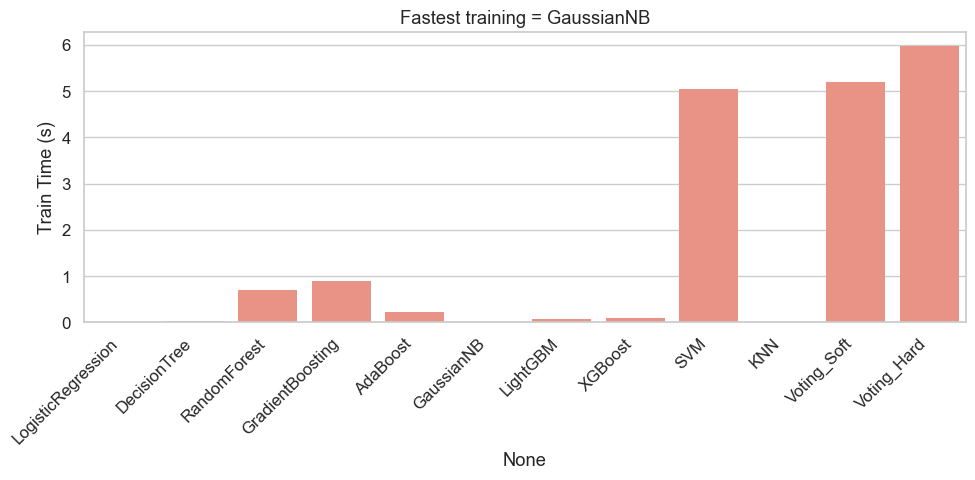

In [13]:
# ─── 3) Training‐time bar (highlight fastest) ──────────────────────────────
fastest = df['Train Time (s)'].idxmin()
colors = ['#2a9d8c' if mdl==fastest else '#FA8775' for mdl in df.index]

plt.figure(figsize=(10,5))
sns.barplot(x=df.index, y=df['Train Time (s)'], palette=colors, edgecolor='none')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Train Time (s)')
plt.title(f'Fastest training = {fastest}')
plt.tight_layout()
for ext in ('png','pdf'):
    plt.savefig(os.path.join(FIG_DIR, f"train_time.{ext}"), dpi=300)
plt.show()
plt.close()

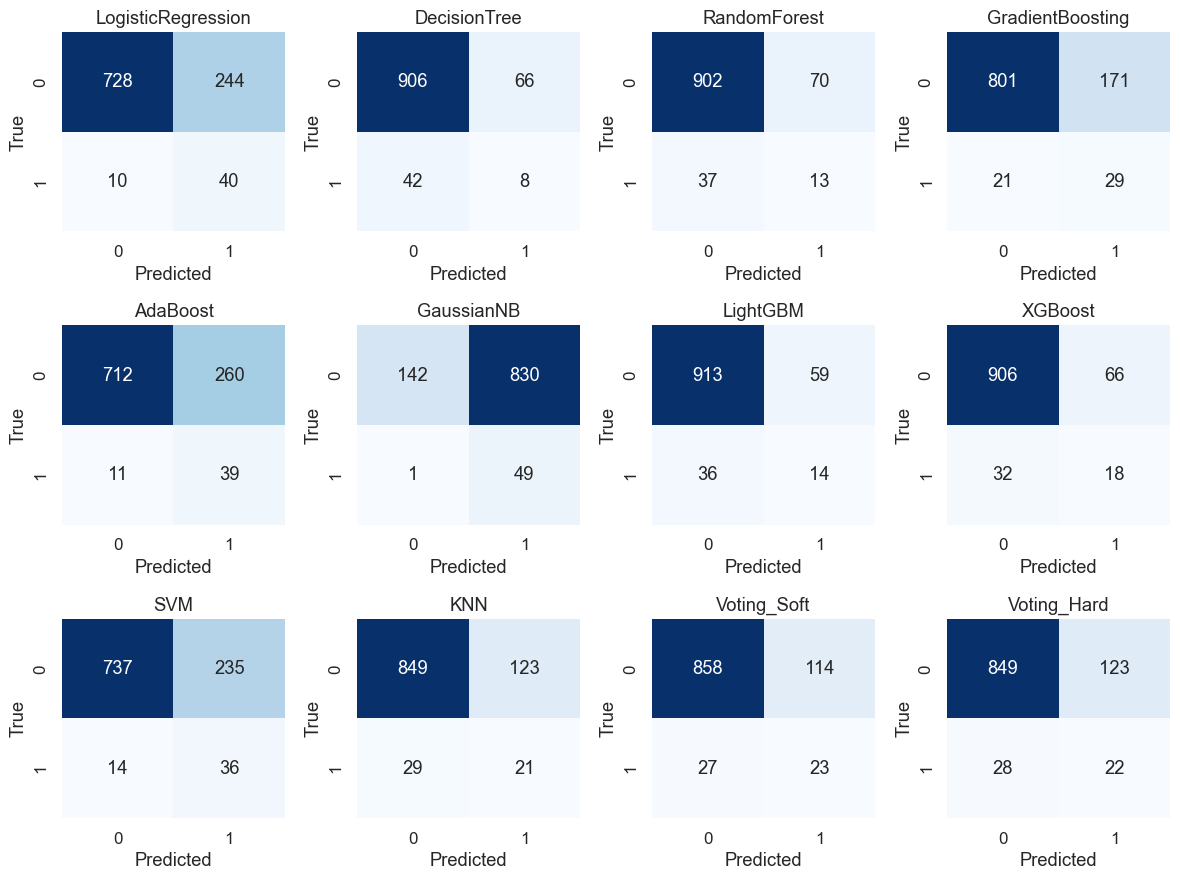

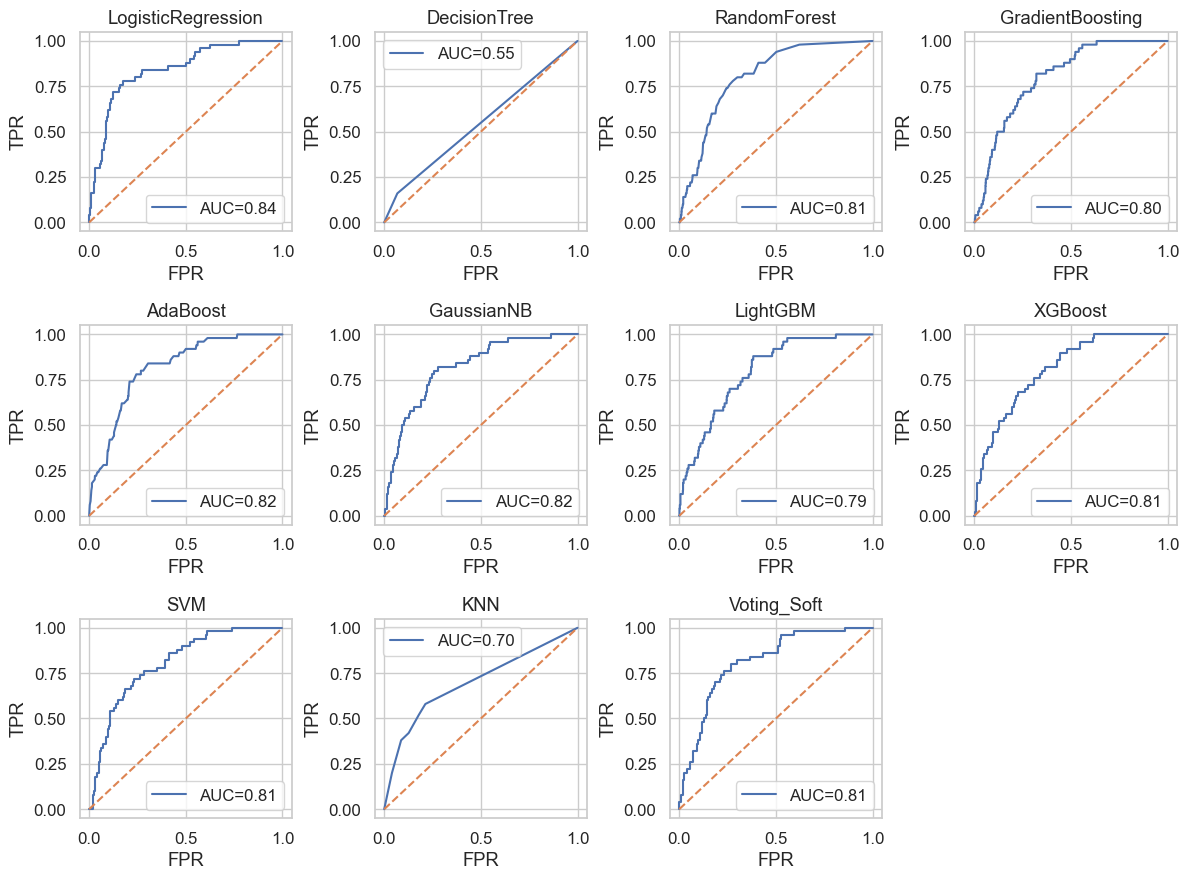

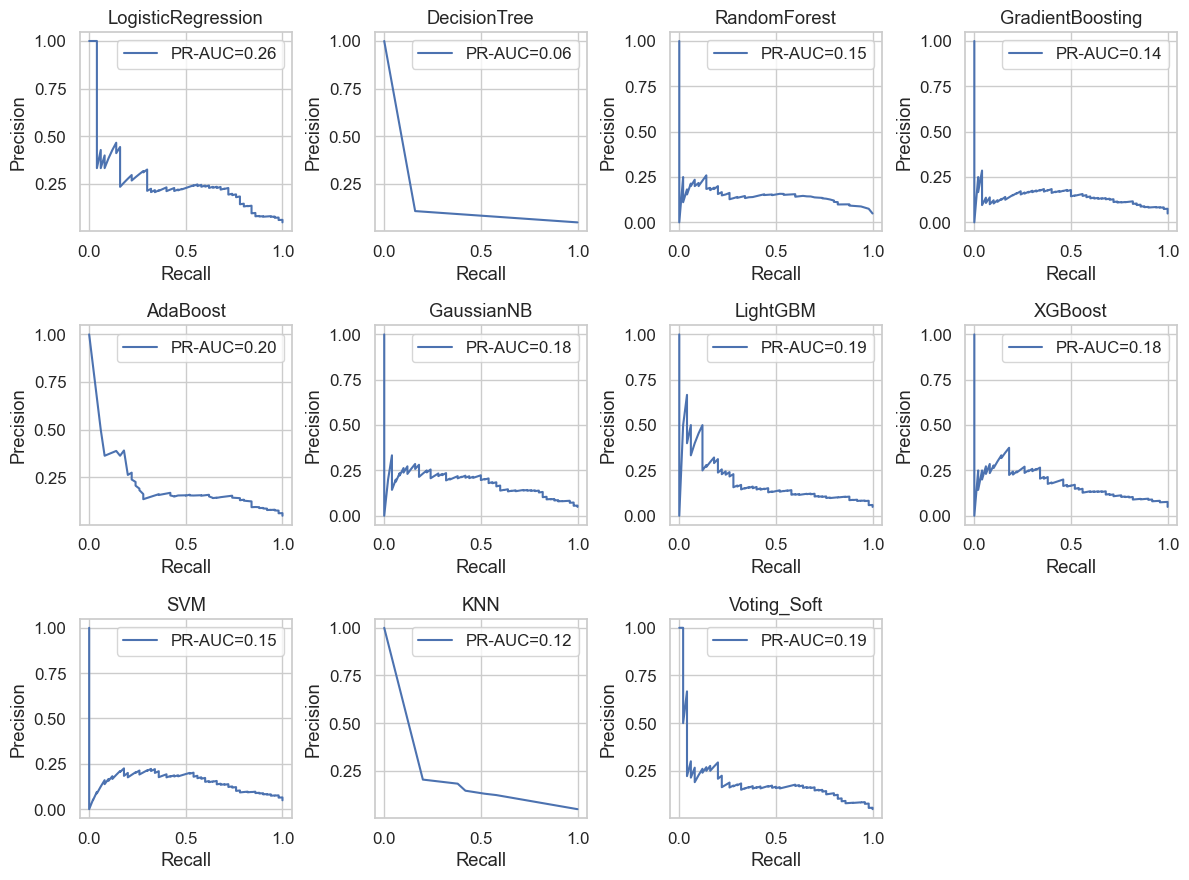

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score
)

# ─── set your output directory ─────────────────────────────────────────────
out_dir = r'F:\stroke-prediction-project\figures\mlga'
os.makedirs(out_dir, exist_ok=True)

# ─── load your GA-11 feature list ──────────────────────────────────────────
CHARM_DIR = r'F:\stroke-prediction-project\data\charm'
feats = pd.read_csv(os.path.join(CHARM_DIR, 'ga_stable11.csv'))['feature'].tolist()

# assume `models`, `X_test`, and `y_test` are already in scope

sns.set(style="whitegrid", font_scale=1.1)

# --- Grid of Confusion Matrices ---
cols = 4
rows = int(np.ceil(len(models) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
for idx, (name, model) in enumerate(models.items()):
    ax = axes.flatten()[idx]
    preds = model.predict(X_test[feats])
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cbar=False, ax=ax, cmap='Blues')
    ax.set_title(name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flatten()[j])
plt.tight_layout()
plt.savefig(f"{out_dir}/confusion_matrices.png", dpi=300)
plt.savefig(f"{out_dir}/confusion_matrices.pdf", dpi=300)
plt.show()
plt.close()

# --- ROC Curves Grid (proba models only) ---
proba_models = {n:m for n,m in models.items() if hasattr(m, 'predict_proba')}
cols = 4
rows = int(np.ceil(len(proba_models) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
for idx, (name, model) in enumerate(proba_models.items()):
    ax = axes.flatten()[idx]
    y_proba = model.predict_proba(X_test[feats])[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    ax.plot(fpr, tpr, label=f'AUC={auc_score:.2f}')
    ax.plot([0, 1], [0, 1], '--')
    ax.set_title(name)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend()
for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flatten()[j])
plt.tight_layout()
plt.savefig(f"{out_dir}/roc_curves.png", dpi=300)
plt.savefig(f"{out_dir}/roc_curves.pdf", dpi=300)
plt.show()
plt.close()

# --- Precision-Recall Curves Grid (proba models only) ---
cols = 4
rows = int(np.ceil(len(proba_models) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
for idx, (name, model) in enumerate(proba_models.items()):
    ax = axes.flatten()[idx]
    y_proba = model.predict_proba(X_test[feats])[:, 1]
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    ax.plot(recall_vals, precision_vals, label=f'PR-AUC={pr_auc:.2f}')
    ax.set_title(name)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()
for j in range(idx+1, rows*cols):
    fig.delaxes(axes.flatten()[j])
plt.tight_layout()
plt.savefig(f"{out_dir}/pr_curves.png", dpi=300)
plt.savefig(f"{out_dir}/pr_curves.pdf", dpi=300)
plt.show()
plt.close()